In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
import os

# modify the project path below accordingly
PATH = "/content/drive/MyDrive/HGR/gesture_face_features"

sys.path.append(os.path.join(PATH, "code", "main"))

data_path = os.path.join(PATH, 'samples', 'sign')
feat_path = os.path.join(PATH, 'data', 'feats')
emb_path = os.path.join(feat_path, 'embeddings')

%load_ext autoreload
%autoreload 2

In [4]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

# loading modules from system path
from loader import SignImageFolder, ModelLoader
from participant import participants, filter_participants, filter_targets
from feature import extract_features, extract_model_features
from feature import filter_by_id, get_f_y_pred
from utils import get_predictions, decode_imagenet, delete_keys, keep_fc
from mte import get_leep_score, get_nleep_score, score_MTE, LogME

In [5]:
MODEL_ZOO = ModelLoader.available_models
LAYER_ZOO = ['avgpool', 'features.8', 'Mixed_7c.branch_pool.conv', 'layer4.2.conv3', 'features.34'] # see ModelLoader.return_nodes_dict

In [6]:
dataset = SignImageFolder(data_path, resize=(528,528))
dataloader = DataLoader(dataset, batch_size=32, num_workers=2)
# have separate dataloader for each model based on input_size
# and recalculate features with extract_features()

In [7]:
feats = extract_model_features(dataloader, feat_path=feat_path)

Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/vgg19_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/resnet50_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/inception_v3_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/efficientnet_b0_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/efficientnet_b1_feats.pt.
Features loaded from /content/drive/MyDrive/HGR/gesture_face_features/data/feats/efficientnet_b6_feats.pt.


In [8]:
for model_name in MODEL_ZOO:
  _, _, _, idx = get_f_y_pred(model_name, feats, dataset.targets)
  label_counts, _ = decode_imagenet(idx)
  print(f'Predictions of {model_name}: {label_counts}')

Predictions of vgg19: {'jersey': 67, 'sweatshirt': 62, 'suit': 34, 'military_uniform': 33, 'cardigan': 4, 'wig': 4, 'abaya': 2}
Predictions of resnet50: {'suit': 113, 'wool': 37, 'jersey': 28, 'wig': 25, 'sunglasses': 2, 'safety_pin': 1}
Predictions of inception_v3: {'jersey': 50, 'wool': 45, 'sweatshirt': 35, 'suit': 27, 'wig': 23, 'Band_Aid': 10, 'velvet': 5, 'sunglasses': 4, 'tench': 3, 'maillot': 2, 'abaya': 1, 'bow_tie': 1}
Predictions of efficientnet_b0: {'sweatshirt': 62, 'suit': 34, 'military_uniform': 34, 'abaya': 32, 'wig': 30, 'jersey': 11, 'wool': 3}
Predictions of efficientnet_b1: {'jersey': 40, 'sweatshirt': 37, 'wool': 37, 'suit': 34, 'abaya': 29, 'necklace': 23, 'perfume': 3, 'sunglasses': 2, 'wig': 1}
Predictions of efficientnet_b6: {'sweatshirt': 66, 'jersey': 38, 'wool': 37, 'suit': 28, 'cardigan': 18, 'wig': 18, 'abaya': 1}


# UMAP

In [9]:
# https://umap-learn.readthedocs.io/en/latest/
!pip install -q umap-learn

In [10]:
# Deletes all features except for avgpool to free RAM
# for model_name in MODEL_ZOO:
#   delete_keys(feats[model_name], keep_key_list=['avgpool'])

In [11]:
# splitting feats based on participants
p = filter_participants(feats, dataset)
t = filter_targets(dataset)

In [12]:
del feats # frees up RAM

In [13]:
import umap
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter("ignore", FutureWarning)

class Reducer:
  def __init__(self, feats, targets, model_name, layer_name, method='umap', n_components=2, random_state=None, emb_path=None):
    self.feats = feats
    self.targets = targets
    self.model_name = model_name
    self.layer_name = layer_name
    self.random_state = random_state
    self.n_components = n_components
    self.embedding = None
    self.params = None
    self.method = method
    self.layer_feats = self._get_layer_feats()
    self.emb_path = emb_path

  def _get_layer_feats(self):
    layer_feats = self.feats[self.model_name][self.layer_name]
    return layer_feats.view(layer_feats.shape[0], -1)

  def _get_file_name(self):
    return  f"{self.method}_{self.model_name}_{self.layer_name}_rs_{str(self.random_state)}.npz"

  def _get_key_name(self, params):
    return ' '.join(str(value) for value in params.values())

  def get_embedding(self, params=None):
    # print(params)
    if self.method == 'umap':
      self.params = params or {
        'n_neighbors': 30,
        'min_dist': 0.3,
        'metric': 'euclidean',
      }
      reducer = umap.UMAP(
        n_components=self.n_components,
        n_neighbors=self.params['n_neighbors'],
        min_dist=self.params['min_dist'],
        metric=self.params['metric'],
        random_state=self.random_state
      )
    elif self.method == 'tsne':
      self.params = params or {
        'perplexity': 10,
        'learning_rate': 300,
        'metric': 'euclidean',
      }
      reducer = TSNE(
        n_components=self.n_components,
        perplexity=self.params['perplexity'],
        learning_rate=self.params['learning_rate'],
        metric=self.params['metric'],
        random_state=self.random_state
      )
    elif self.method == 'pca':
      self.params = params or {
          'whiten': False,
          'svd_solver': 'full',
      }
      reducer = PCA(
          n_components=self.n_components,
          whiten=self.params['whiten'],
          svd_solver=self.params['svd_solver'],
          random_state=self.random_state
      )

    self.embedding = reducer.fit_transform(self.layer_feats)

  def get_embedding_from_disk(self, params, verbose=False):
    if not self.emb_path or not params:
      print('No path or params to load form disk.')
      return

    file_name = self._get_file_name()
    key_name = self._get_key_name(params)
    file_path = os.path.join(self.emb_path, file_name)

    if os.path.exists(file_path):
      with np.load(file_path, allow_pickle=True) as f:
        data = dict(f)
        if key_name in data:
          self.embedding = data[key_name]
          self.params = params
          if verbose:
            print(f'Data loaded for {file_name}')
        else:
          self.get_embedding(params)
          data[key_name] = self.embedding
          np.savez(file_path, **data)
          if verbose:
            print(f"Data saved to {file_path}.")
        del data
    else:
      self.get_embedding(params)
      np.savez(file_path, **{key_name: self.embedding})
      if verbose:
        print(f"Data saved to {file_path}.")

  def plot(self, idx_to_class=None):
      scatter = plt.scatter(
        self.embedding[:, 0],
        self.embedding[:, 1],
        c=self.targets,
        cmap='viridis'
      )

      unique_targets = np.unique(self.targets)
      handles = []
      for target in unique_targets:
        letter = idx_to_class[target] if idx_to_class else target
        handle = plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=plt.cm.viridis(target / max(unique_targets)),
                            markersize=10, label=letter)
        handles.append(handle)

      plt.legend(handles=handles, title="Letters", bbox_to_anchor=(1.05, 1), loc='upper left')
      plt.show()

  def __repr__(self):
    return f"Embedding shape: {self.embedding.shape}, {self.method} params: {self.params})"

class ReducerEngine:
  def __init__(self, feats, targets, method='umap', param_grids=None, n_components=2, random_state=None, emb_path=None):
    self.feats = feats
    self.targets = np.array(targets)
    self.method = method
    self.param_grids = param_grids or {
      'umap': {
        'n_neighbors': [5, 10, 15, 30],
        'min_dist': [0.01, 0.05, 0.1, 0.3],
        'metric': ["euclidean", "cosine"]
      },
      'tsne': {
        'perplexity': [10, 15, 20, 25],
        'learning_rate': [100, 300, 600, 1000],
        'metric': ["euclidean", "cosine"]
      },
      'pca': {
        'whiten': [True, False],
        'svd_solver': ['full', 'auto'],
      }
    }
    self.n_components = n_components
    self.random_state = random_state
    self.reducers = []
    self.emb_path = emb_path

  def get_all_embeddings(self, model_name_list, layer_name_list, from_disk=True):
    print(f'Getting {self.method} embeddings for grid {self.param_grids[self.method]}.')
    for model_name in model_name_list:
      for layer_name in layer_name_list:
        if layer_name in self.feats[model_name].keys():
          print(f'-------- {model_name} {layer_name} ---------')
          for params in ParameterGrid(self.param_grids[self.method]):
            reducer = Reducer(self.feats, self.targets, model_name, layer_name, self.method, self.n_components, self.random_state, self.emb_path)
            if from_disk:
              reducer.get_embedding_from_disk(params, verbose=False)
            else:
              reducer.get_embedding(params)
            self.reducers.append(reducer)

In [14]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

class Embedding:
  def __init__(self, reducer, model='kmeans', random_state=None):
    self.reducer = reducer
    self.random_state = random_state
    self.model = model
    self.cluster = None
    self.n_clusters = len(np.unique(self.reducer.targets))

  def get_clusters(self):
    if self.model == 'kmeans':
      model = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
    elif self.model == 'gmm':
      model = GaussianMixture(n_components=self.n_clusters, random_state=self.random_state)
    self.cluster = model.fit_predict(self.reducer.embedding)

  def __repr__(self):
    return f"Embedding for {self.model}"

class EmbeddingEngine:
  def __init__(self, reducer_engine, model='kmeans', random_state=None):
    self.reducer_engine = reducer_engine
    self.random_state = random_state
    self.model = model
    self.clusters = []

  def get_all_clusters(self):
    print(f'Getting {self.model} clusters...')
    for reducer in self.reducer_engine.reducers:
      # print(f'-------- {reducer.model_name} {reducer.layer_name} ---------')
      cluster = Embedding(reducer, self.model, self.random_state)
      cluster.get_clusters()
      self.clusters.append(cluster)

In [112]:
import itertools
from collections import Counter

class Cluster:
  def __init__(self, embedding, idx_to_class=None):
    self.embedding = embedding
    self.idx_to_class = idx_to_class or {
        0: 'A', 1: 'H', 2: 'L',
        3: 'N', 4: 'O', 5: 'P', 6: 'R'
    }
    self.similarity_scores = self._build_similarity_scores()
    self.cluster_groups = self.group()
    self.score = self.evaluate()
    self.purity = self.get_purity()
    self.nleep_score = 0

  def _build_similarity_scores(self):
    similarity_scores = {
      ("R", "N"): 0.8,
      ("H", "P"): 0.8,
      ("P", "L"): 0.8,
      ("R", "O"): 0.6,
      ("N", "O"): 0.6,
      ("H", "L"): 0.6,
    }
    similarity_scores.update({(b, a): score for (a, b), score in similarity_scores.items()})
    for letter in 'AHLNPRO':
        similarity_scores[(letter, letter)] = 1.0
    return similarity_scores

  def evaluate(self):
    count = self.embedding.n_clusters
    total = sum(self.eval_single(i) for i in range(count))
    return total/count

  def eval_single(self, cluster_num):
    letters = list(self.cluster_groups.values())[cluster_num]
    # if a single letter in a cluster then score is 0
    if len(letters) == 1:
      return 0
    pairs = list(itertools.combinations(letters, 2))
    score = sum(self.similarity_scores.get(pair, 0) for pair in pairs)/len(pairs)
    return score

  def group(self):
    data = np.column_stack((self.embedding.cluster, self.embedding.reducer.targets))
    cluster_groups = {}
    for cluster, target in data:
        cluster_groups.setdefault(cluster, []).append(self.idx_to_class[target])
    return cluster_groups

  def get_purity(self):
    total_samples = len(self.embedding.reducer.targets)
    return sum(max(Counter(letter_group).values()) for letter_group in self.cluster_groups.values()) / total_samples

  def __repr__(self):
      cluster_details = f"-------{self.embedding.reducer.model_name} "
      cluster_details += f"{self.embedding.reducer.layer_name}-------\n\n"
      for cluster, letter_group in self.cluster_groups.items():
          cluster_details += f"Cluster {cluster}: {letter_group}\n"
      cluster_details += f"\nPurity: {self.purity:.2f}\n"
      cluster_details += f"Custom Weighted Score: {self.score:.2f}\n"
      return cluster_details


class ClusterEngine:
  def __init__(self, embedding_engine):
    self.embedding_engine = embedding_engine
    self.scored_clusters = []
    self.best_cluster = None
    self.best_score = 0

  def score_all_clusters(self):
    print(f'Getting cluster scores...')
    for embedding in self.embedding_engine.clusters:
      # print(f'-------- {model_name} {layer_name} ---------')
      cluster = Cluster(embedding)
      # print(cluster)
      self.scored_clusters.append(cluster)
      if cluster.score > self.best_score:
        self.best_score = cluster.score
        self.best_cluster = cluster


In [21]:
res = {'umap': [], 'tsne': [], 'pca': []}
for method in ['umap', 'tsne']:
  for i in range(6):
    re = ReducerEngine(p[i], t[i], method=method, emb_path=os.path.join(emb_path, str(i)))
    re.get_all_embeddings(MODEL_ZOO, LAYER_ZOO)
    res[method].append(re)

Getting umap embeddings for grid {'n_neighbors': [5, 10, 15, 30], 'min_dist': [0.01, 0.05, 0.1, 0.3], 'metric': ['euclidean', 'cosine']}.
-------- vgg19 avgpool ---------
-------- vgg19 features.34 ---------
-------- resnet50 avgpool ---------
-------- resnet50 layer4.2.conv3 ---------
-------- inception_v3 avgpool ---------
-------- inception_v3 Mixed_7c.branch_pool.conv ---------
-------- efficientnet_b0 avgpool ---------
-------- efficientnet_b0 features.8 ---------
-------- efficientnet_b1 avgpool ---------
-------- efficientnet_b1 features.8 ---------
-------- efficientnet_b6 avgpool ---------
-------- efficientnet_b6 features.8 ---------
Getting umap embeddings for grid {'n_neighbors': [5, 10, 15, 30], 'min_dist': [0.01, 0.05, 0.1, 0.3], 'metric': ['euclidean', 'cosine']}.
-------- vgg19 avgpool ---------
-------- vgg19 features.34 ---------
-------- resnet50 avgpool ---------
-------- resnet50 layer4.2.conv3 ---------
-------- inception_v3 avgpool ---------
-------- inception_v3

In [22]:
!git clone -q https://github.com/thuml/LogME.git

fatal: destination path 'LogME' already exists and is not an empty directory.


In [157]:
from LogME.LEEP import LEEP

class ScoringEngine:
  def __init__(self, reducer_engine, model='kmeans'):
    self.re = reducer_engine
    self.ee = None
    self.ce = None
    self.model = model
    self.nleep_scores = None
    self.scores = None

  def score(self, verbose=True):
    self.ee = EmbeddingEngine(self.re, self.model)
    self.ee.get_all_clusters()
    self.ce = ClusterEngine(self.ee)
    self.ce.score_all_clusters()
    if verbose:
      print(self.ce.best_cluster)
      self.ce.best_cluster.embedding.reducer.plot()

  def get_nleep_score(self, cluster=None):
    cluster = cluster or self.ce.best_cluster
    n_components = cluster.embedding.n_clusters
    embedding = cluster.embedding.reducer.embedding
    random_state = cluster.embedding.random_state
    targets = cluster.embedding.reducer.targets

    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    gmm.fit(embedding)
    gmm_predictions = gmm.predict_proba(embedding)
    cluster.nleep_score = LEEP(gmm_predictions, targets)
    return cluster.nleep_score

  def get_nleep_scores(self):
    for cluster in self.ce.scored_clusters:
      self.get_nleep_score(cluster)

  def corr(self):
    if not self.nleep_scores:
      self.nleep_scores = [cluster.nleep_score for cluster in self.ce.scored_clusters]
    if not self.scores:
      self.scores = [cluster.score for cluster in self.ce.scored_clusters]
    correlation = np.corrcoef(self.scores, self.nleep_scores)[0, 1]
    print(f"Pearson Correlation: {correlation}")
    plt.scatter(self.scores, self.nleep_scores)

  def get_best_cluster(self, model_name, method='score'):
    best_score = float('-inf')
    best_cluster = None
    for cluster in self.ce.scored_clusters:
      if model_name == cluster.embedding.reducer.model_name:
        score = cluster.nleep_score if method == 'nleep' else cluster.score
        if score > best_score:
          best_score = score
          best_cluster = cluster
    return best_cluster

  def rank(self, model_name_list, method='score', verbose=True):
    clusters = []
    for model_name in model_name_list:
      best_cluster = self.get_best_cluster(model_name, method)
      clusters.append(best_cluster)
    clusters = sorted(clusters, key=lambda cluster: cluster.nleep_score if method == 'nleep' else cluster.score, reverse=True)

    if verbose:
      print(f'----Model {method} rankings----\n')
      for cluster in clusters:
        if method == 'score':
          print(f'{cluster.embedding.reducer.model_name} : {round(cluster.score, 2)}')
        elif method == 'nleep':
          print(f'{cluster.embedding.reducer.model_name} : {round(cluster.nleep_score, 2)}')

Getting kmeans clusters...
Getting cluster scores...
-------efficientnet_b6 avgpool-------

Cluster 4: ['A', 'A', 'A']
Cluster 0: ['A', 'A', 'A']
Cluster 1: ['H', 'H', 'H', 'H', 'L', 'P', 'P', 'P']
Cluster 3: ['H', 'L', 'L', 'L', 'L', 'P', 'P']
Cluster 2: ['N', 'N', 'R', 'R', 'R']
Cluster 6: ['N', 'N', 'O', 'R']
Cluster 5: ['O', 'O', 'O']

Purity: 0.67
Custom Weighted Score: 0.90



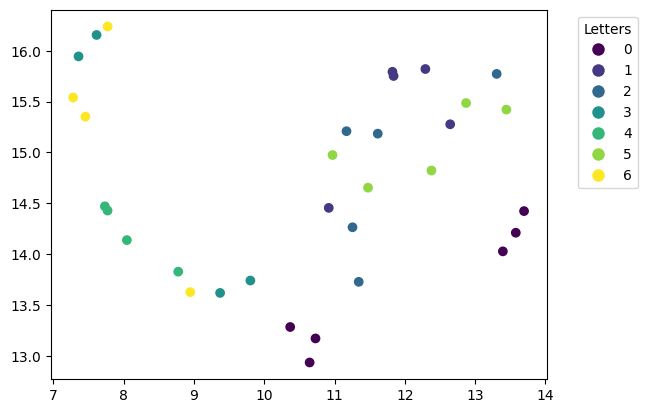

In [184]:
se = ScoringEngine(res['umap'][1])
se.score()

In [180]:
se.get_nleep_scores()

In [181]:
se.rank(MODEL_ZOO, 'nleep')

----Model nleep rankings----

efficientnet_b1 : -0.34
efficientnet_b6 : -0.36
inception_v3 : -0.41
efficientnet_b0 : -0.44
resnet50 : -0.47
vgg19 : -0.67


In [182]:
se.rank(MODEL_ZOO)

----Model score rankings----

efficientnet_b6 : 0.93
efficientnet_b1 : 0.92
efficientnet_b0 : 0.9
resnet50 : 0.86
inception_v3 : 0.84
vgg19 : 0.75


# Model Transferability Estimation

https://github.com/thuml/Transfer-Learning-Library/tree/master/examples/model_selection

In [ ]:
# targets = np.array(dataset.targets, dtype=np.int32)
# for model_name in MODEL_ZOO:
#   fc_layer = list(feats[model_name].keys())[-1]
#   f = feats[model_name][fc_layer]
#   # preds = F.softmax(f, dim=1).numpy()
#   score = get_nleep_score(f, targets, 35)
#   print(f'NLEEP score for {model_name}: {score}')

NLEEP score for vgg19: -1.1026206016540527
NLEEP score for resnet50: -1.0406854152679443
NLEEP score for inception_v3: -1.1728464365005493
NLEEP score for efficientnet_b0: -1.062324047088623
NLEEP score for efficientnet_b1: -1.0187960863113403
NLEEP score for efficientnet_b6: -1.144242525100708


In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.mixture import GaussianMixture
# import numpy as np

# random_state = 42
# num_components_pca = 35  # Number of components for PCA (adjust as needed)

# targets = np.array(dataset.targets, dtype=np.int32)
# for model_name in MODEL_ZOO:
#   fc_layer = list(feats[model_name].keys())[-1]
#   f = feats[model_name][fc_layer]
#   # preds = F.softmax(f, dim=1).numpy()
#   pca = PCA(n_components=num_components_pca, random_state=random_state)
#   reduced_features = pca.fit_transform(f)

#   explained_variance_ratio = pca.explained_variance_ratio_
#   pca_energy = np.cumsum(explained_variance_ratio)

#   num_components_gmm = 35
#   gmm = GaussianMixture(n_components=num_components_gmm, random_state=random_state)
#   gmm.fit(reduced_features)
#   gmm_predictions = gmm.predict_proba(reduced_features)
#   nleep = get_leep_score(gmm_predictions.astype('float32'), targets)
#   # print("PCA Explained Variance Ratio:", np.sum(pca.explained_variance_ratio_), pca_energy)
#   print(f"NLEEP Score for {model_name}: {nleep}")

NLEEP Score for vgg19: -1.0961130857467651
NLEEP Score for resnet50: -1.0729265213012695
NLEEP Score for inception_v3: -1.0495256185531616
NLEEP Score for efficientnet_b0: -1.0380001068115234
NLEEP Score for efficientnet_b1: -0.8942098617553711
NLEEP Score for efficientnet_b6: -1.0076889991760254


In [ ]:
!git clone -q https://github.com/thuml/LogME.git

In [ ]:
from LogME.LogME import LogME
from LogME.LEEP import LEEP
from LogME.NCE import NCE

In [ ]:
targets = np.array(dataset.targets)
for model_name in MODEL_ZOO:
  fc_layer = list(feats[model_name].keys())[-1]
  f = feats[model_name][fc_layer]
  preds = F.softmax(f, dim=1).numpy()
  score = LEEP(preds, targets)
  print(f'LEEP score for {model_name}: {score}')

LEEP score for vgg19: -1.92770825355806
LEEP score for resnet50: -1.9434076109575982
LEEP score for inception_v3: -1.9360990636225066
LEEP score for efficientnet_b0: -1.9289171695876328
LEEP score for efficientnet_b1: -1.9320151866958826
LEEP score for efficientnet_b6: -1.9137111650971603


In [ ]:
logme = LogME()

targets = np.array(dataset.targets)
for model_name in MODEL_ZOO:
  fc_layer = list(feats[model_name].keys())[-1]
  f = feats[model_name][fc_layer]
  preds = F.softmax(f, dim=1).numpy()
  score = logme.fit(preds, targets)
  print(f'LogME score for {model_name}: {score}')

LogME score for vgg19: -2.257169256187553
LogME score for resnet50: -5.491077958443078
LogME score for inception_v3: -6.446164371475224


/content/LogME/LogME.py:172: UserWarning: re-fitting for new data. old parameters cleared.
  warnings.warn('re-fitting for new data. old parameters cleared.')


LogME score for efficientnet_b0: 3.0739671979375203
LogME score for efficientnet_b1: 0.640813031838806
LogME score for efficientnet_b6: 1.2337664315449643


In [ ]:
# p = filter_participants(feats, dataset)
# t = filter_targets(dataset)

In [ ]:
# for i in range(6):
#   print(f'Participant {i}')
#   for model_name in MODEL_ZOO:
#     fc_layer = list(p[i][model_name].keys())[-1]
#     f = p[i][model_name][fc_layer]
#     preds = F.softmax(f, dim=1).numpy()
#     score = LEEP(preds, t[i])
#     print(f'LEEP score for {model_name}: {score}')
#   print()